RRL Trading System - Training and Testing
Generating artificial price data...
Training data points: 1000
Test data points: 551

TESTING WITH RETURN OPTIMIZATION
Starting RRL Training...
Parameters: M=10, T=100, optimization=return
Transaction costs=0.001, mu=1, iterations=10
--------------------------------------------------
Training progress:
Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Not enough data for iteration 9, stopping early
Training completed!

Testing RRL Model...
------------------------------

Training Results (return):
  Total Return (RRL): -0.2900
  Total Return (Market): -0.2646
  Sharpe Ratio (RRL): -0.1862
  Sharpe Ratio (Market): -0.1606

Testing Results (return):
  Total Return (RRL): 0.2237
  Total Return (Market): 0.3162
  Sharpe Ratio (RRL): 0.1217
  Sharpe Ratio (Market): 0.1529


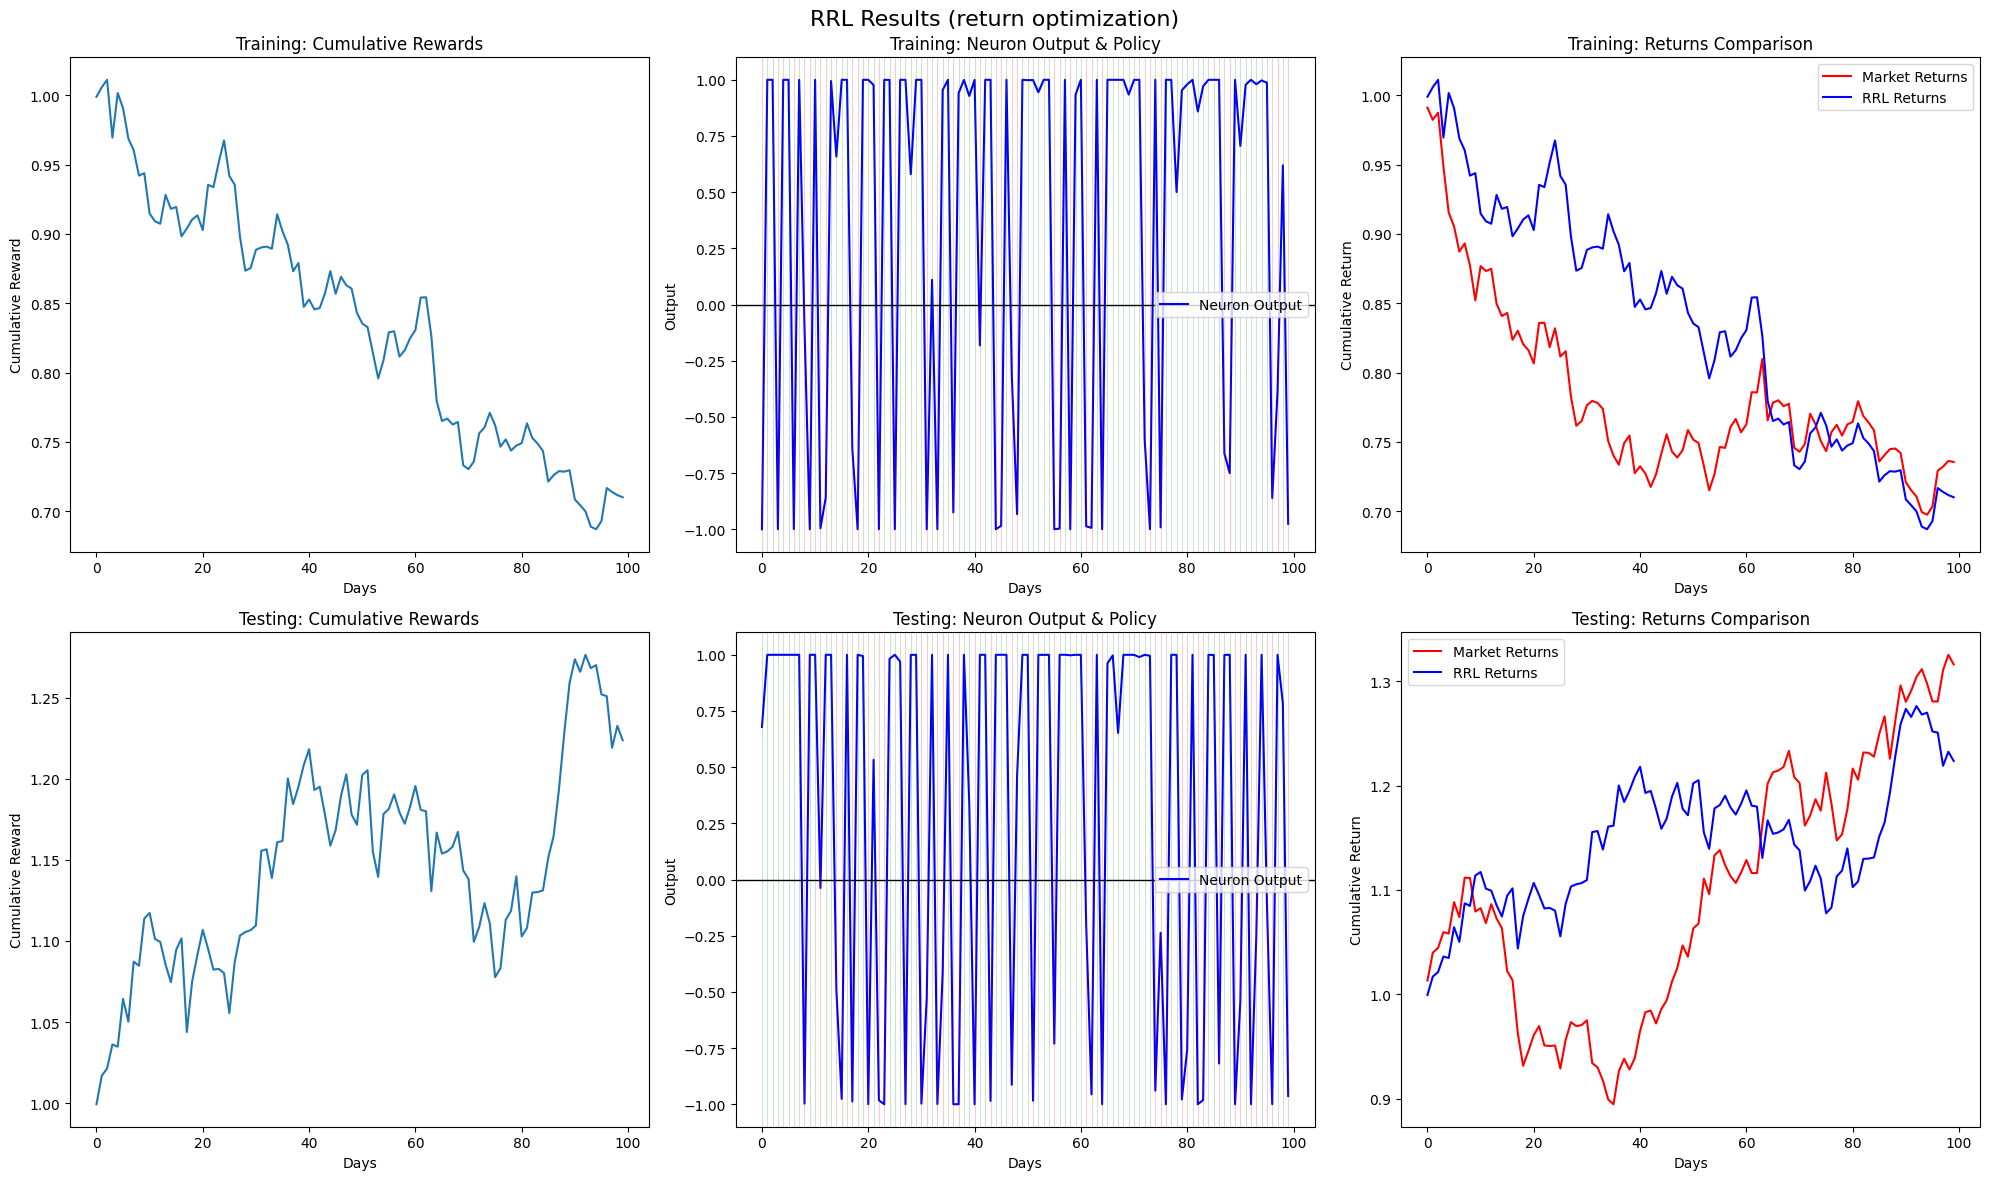


TESTING WITH SHARPERATIO OPTIMIZATION
Starting RRL Training...
Parameters: M=10, T=100, optimization=sharpeRatio
Transaction costs=0.001, mu=1, iterations=10
--------------------------------------------------
Training progress:
Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Not enough data for iteration 9, stopping early
Training completed!

Testing RRL Model...
------------------------------

Training Results (sharpeRatio):
  Total Return (RRL): -0.2883
  Total Return (Market): -0.2646
  Sharpe Ratio (RRL): -0.1802
  Sharpe Ratio (Market): -0.1606

Testing Results (sharpeRatio):
  Total Return (RRL): 0.1642
  Total Return (Market): 0.3162
  Sharpe Ratio (RRL): 0.0894
  Sharpe Ratio (Market): 0.1529


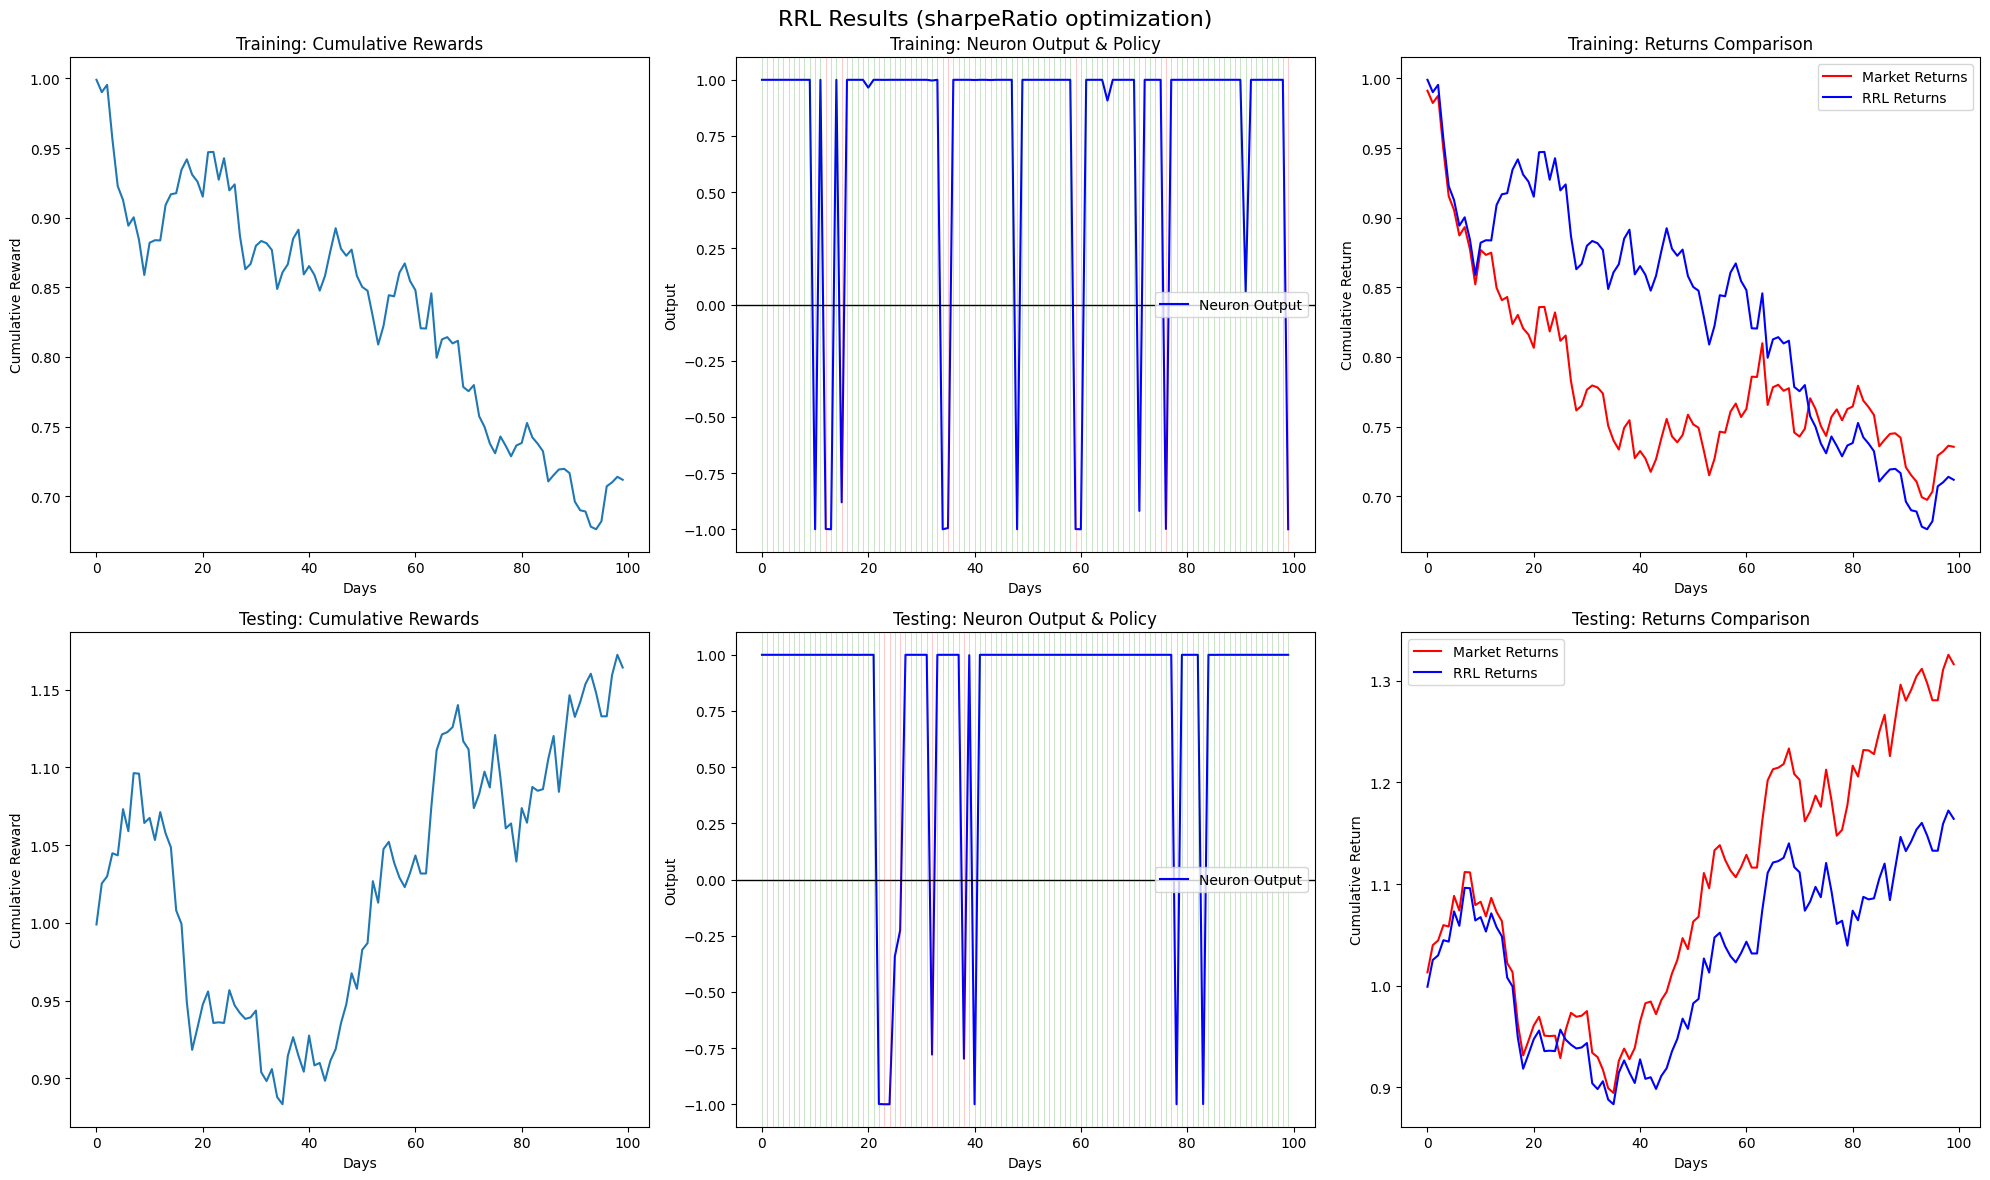


RRL Training and Testing Completed!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import fmin_ncg
import CoreFunctions_v6 as cf
import UtilityFunctions as uf

# Set random seed for reproducibility
np.random.seed(42)

def generate_artificial_price_data(n_points=2000, initial_price=100, volatility=0.02, trend=0.0001):
    """
    Generate artificial price data with trend and volatility
    """
    returns = np.random.normal(trend, volatility, n_points)
    prices = np.zeros(n_points + 1)
    prices[0] = initial_price
    
    for i in range(1, n_points + 1):
        prices[i] = prices[i-1] * (1 + returns[i-1])
    
    return prices

def train_rrl_model(training_data, M=10, T=100, optimization_function="return", 
                   initial_theta=1, transaction_costs=0.001, mu=1, rho = 0.01,iterations=15):
    """
    Train the RRL model on the given data
    """
    print("Starting RRL Training...")
    print(f"Parameters: M={M}, T={T}, optimization={optimization_function}")
    print(f"Transaction costs={transaction_costs}, mu={mu}, iterations={iterations}")
    print("-" * 50)
    
    # Generate returns and normalize
    X = uf.GetReturns(training_data)
    Xn = uf.FeatureNormalize(X)
    
    # Initialize theta
    theta = np.ones(M + 2) * initial_theta
    
    # Training loop
    start_pos = M + T
    
    print("Training progress:")
    for i in range(1, iterations + 1):
        print(f"Iteration {i}/{iterations}")
        
        # Train using gradient descent
        theta = cf.train(theta, X, Xn, T, M, mu, transaction_costs, 
                        start_pos, rho, 500, optimization_function)
        start_pos += T
        
        # Check if we have enough data for next iteration
        if start_pos + T >= len(X):
            print(f"Not enough data for iteration {i+1}, stopping early")
            break
    
    print("Training completed!")
    return theta, X, Xn

def test_rrl_model(theta, test_data, X_train, Xn_train, M=10, T=100, 
                  transaction_costs=0.001, mu=1):
    """
    Test the trained RRL model on test data
    """
    print("\nTesting RRL Model...")
    print("-" * 30)
    
    # Generate returns for test data
    X_test = uf.GetReturns(test_data)
    Xn_test = uf.FeatureNormalize(X_test)
    
    # Use the same normalization parameters from training
    # (In practice, you'd want to store and reuse the normalization parameters)
    
    start_pos = M
    test_length = min(T, len(X_test) - start_pos)
    
    # Compute neuron output for test period
    F = cf.ComputeF(theta, Xn_test, test_length, M, start_pos)
    
    # Compute rewards
    rewards = cf.RewardFunction(mu, F, transaction_costs, test_length, M, X_test)
    
    return F, rewards, X_test

def plot_results(F_train, rewards_train, returns_train, F_test, rewards_test, 
                returns_test, title_suffix=""):
    """
    Plot training and testing results
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'RRL Results {title_suffix}', fontsize=16)
    
    # Training results
    # Cumulative rewards
    cum_rewards_train = np.cumprod(rewards_train + 1)
    axes[0, 0].plot(cum_rewards_train)
    axes[0, 0].set_title('Training: Cumulative Rewards')
    axes[0, 0].set_xlabel('Days')
    axes[0, 0].set_ylabel('Cumulative Reward')
    
    # Neuron output and policy
    axes[0, 1].plot(F_train[1:], 'b-', label='Neuron Output')
    axes[0, 1].axhline(y=0, color='k', linestyle='-', linewidth=1)
    
    # Policy visualization
    B_train = F_train[1:] > 0
    for i, b in enumerate(B_train):
        color = 'g' if b else 'r'
        axes[0, 1].axvline(x=i, color=color, alpha=0.3, linewidth=0.5)
    
    axes[0, 1].set_title('Training: Neuron Output & Policy')
    axes[0, 1].set_xlabel('Days')
    axes[0, 1].set_ylabel('Output')
    axes[0, 1].legend()
    
    # Returns comparison
    cum_returns_train = np.cumprod(returns_train + 1)
    axes[0, 2].plot(cum_returns_train, 'r-', label='Market Returns')
    axes[0, 2].plot(cum_rewards_train, 'b-', label='RRL Returns')
    axes[0, 2].set_title('Training: Returns Comparison')
    axes[0, 2].set_xlabel('Days')
    axes[0, 2].set_ylabel('Cumulative Return')
    axes[0, 2].legend()
    
    # Testing results
    # Cumulative rewards
    cum_rewards_test = np.cumprod(rewards_test + 1)
    axes[1, 0].plot(cum_rewards_test)
    axes[1, 0].set_title('Testing: Cumulative Rewards')
    axes[1, 0].set_xlabel('Days')
    axes[1, 0].set_ylabel('Cumulative Reward')
    
    # Neuron output and policy
    axes[1, 1].plot(F_test[1:], 'b-', label='Neuron Output')
    axes[1, 1].axhline(y=0, color='k', linestyle='-', linewidth=1)
    
    # Policy visualization
    B_test = F_test[1:] > 0
    for i, b in enumerate(B_test):
        color = 'g' if b else 'r'
        axes[1, 1].axvline(x=i, color=color, alpha=0.3, linewidth=0.5)
    
    axes[1, 1].set_title('Testing: Neuron Output & Policy')
    axes[1, 1].set_xlabel('Days')
    axes[1, 1].set_ylabel('Output')
    axes[1, 1].legend()
    
    # Returns comparison
    cum_returns_test = np.cumprod(returns_test + 1)
    axes[1, 2].plot(cum_returns_test, 'r-', label='Market Returns')
    axes[1, 2].plot(cum_rewards_test, 'b-', label='RRL Returns')
    axes[1, 2].set_title('Testing: Returns Comparison')
    axes[1, 2].set_xlabel('Days')
    axes[1, 2].set_ylabel('Cumulative Return')
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()

def calculate_performance_metrics(rewards, returns):
    """
    Calculate performance metrics
    """
    cum_rewards = np.cumprod(rewards + 1)
    cum_returns = np.cumprod(returns + 1)
    
    total_return_rrl = cum_rewards[-1] - 1
    total_return_market = cum_returns[-1] - 1
    
    try:
        sharpe_rrl = cf.SharpeRatio(rewards)
    except:
        sharpe_rrl = np.nan
    
    try:
        sharpe_market = cf.SharpeRatio(returns)
    except:
        sharpe_market = np.nan
    
    return {
        'total_return_rrl': total_return_rrl,
        'total_return_market': total_return_market,
        'sharpe_rrl': sharpe_rrl,
        'sharpe_market': sharpe_market,
        'final_value_rrl': cum_rewards[-1],
        'final_value_market': cum_returns[-1]
    }

def main():
    """
    Main function to run the complete RRL training and testing pipeline
    """
    print("RRL Trading System - Training and Testing")
    print("=" * 50)
    
    # Parameters
    M = 10  # Memory window
    T = 100  # Training window
    transaction_costs = 0.001
    mu = 1
    initial_theta = 1
    iterations = 10
    
    # Generate artificial data
    print("Generating artificial price data...")
    total_points = 1500
    training_points = 1000
    
    # Generate price data with some trend and volatility
    all_prices = generate_artificial_price_data(
        n_points=total_points, 
        initial_price=100, 
        volatility=0.02, 
        trend=0.0005
    )
    
    # Split into training and testing
    training_data = all_prices[:training_points]
    test_data = all_prices[training_points-50:]  # Overlap for continuity
    
    print(f"Training data points: {len(training_data)}")
    print(f"Test data points: {len(test_data)}")
    
    # Test both optimization functions
    for opt_func in ["return", "sharpeRatio"]:
        print(f"\n{'='*60}")
        print(f"TESTING WITH {opt_func.upper()} OPTIMIZATION")
        print(f"{'='*60}")
        
        # Train the model
        theta, X_train, Xn_train = train_rrl_model(
            training_data, M, T, opt_func, initial_theta, 
            transaction_costs, mu, iterations
        )
        
        # Get training results for plotting
        start_pos = M
        F_train = cf.ComputeF(theta, Xn_train, T, M, start_pos)
        rewards_train = cf.RewardFunction(mu, F_train, transaction_costs, T, M, X_train)
        returns_train = X_train[start_pos:start_pos+T]
        
        # Test the model
        F_test, rewards_test, X_test = test_rrl_model(
            theta, test_data, X_train, Xn_train, M, T, transaction_costs, mu
        )
        
        start_pos_test = M
        test_length = len(rewards_test)
        returns_test = X_test[start_pos_test:start_pos_test+test_length]
        
        # Calculate performance metrics
        train_metrics = calculate_performance_metrics(rewards_train, returns_train)
        test_metrics = calculate_performance_metrics(rewards_test, returns_test)
        
        # Print results
        print(f"\nTraining Results ({opt_func}):")
        print(f"  Total Return (RRL): {train_metrics['total_return_rrl']:.4f}")
        print(f"  Total Return (Market): {train_metrics['total_return_market']:.4f}")
        print(f"  Sharpe Ratio (RRL): {train_metrics['sharpe_rrl']:.4f}")
        print(f"  Sharpe Ratio (Market): {train_metrics['sharpe_market']:.4f}")
        
        print(f"\nTesting Results ({opt_func}):")
        print(f"  Total Return (RRL): {test_metrics['total_return_rrl']:.4f}")
        print(f"  Total Return (Market): {test_metrics['total_return_market']:.4f}")
        print(f"  Sharpe Ratio (RRL): {test_metrics['sharpe_rrl']:.4f}")
        print(f"  Sharpe Ratio (Market): {test_metrics['sharpe_market']:.4f}")
        
        # Plot results
        plot_results(F_train, rewards_train, returns_train, 
                    F_test, rewards_test, returns_test, 
                    title_suffix=f"({opt_func} optimization)")
    
    print(f"\n{'='*50}")
    print("RRL Training and Testing Completed!")
    print(f"{'='*50}")

if __name__ == "__main__":
    main()
